In [4]:
library(tidyverse)

In [5]:
offense <- read_csv('data/offense.csv')
offense$Year <- offense$Year + 1

defense <- read_csv('data/defense.csv')
defense$Year <- defense$Year + 1

salary <- read_csv('data/salary.csv')
salary$X1 <- NULL
colnames(salary)[1:2] <- c('Team', 'Year')

standings <- read_csv('data/standings.csv')

Parsed with column specification:
cols(
  Team = col_character(),
  Year = col_integer(),
  `Yds/G_rush` = col_double(),
  TD_rush = col_double(),
  `Yds/G_pass` = col_double(),
  Pct = col_double(),
  TD_pass = col_double(),
  Sck = col_double(),
  Rate = col_double(),
  `Pts/G` = col_double(),
  `Pen Yds` = col_double(),
  TO = col_double()
)
Parsed with column specification:
cols(
  Team = col_character(),
  Year = col_integer(),
  `Yds/G_rush` = col_double(),
  TD_rush = col_double(),
  `Yds/G_pass` = col_double(),
  TD_pass = col_double(),
  Rate = col_double(),
  Sck = col_double(),
  Pct = col_double(),
  `Pts/G` = col_double(),
  `Pen Yds` = col_double()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  team = col_character(),
  year = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  Team = col_character(),
  Year = col_int

In [23]:
combined <- merge(offense, defense, by=c('Team', 'Year'), suffixes=c('_off', '_def'))
combined <- merge(combined, salary, by=c('Team', 'Year'))
combined <- merge(combined, standings, by=c('Team', 'Year'), all=TRUE)

In [24]:
X <- select(combined, colnames(combined)[c(1:39)])
y <- select(combined, colnames(combined)[c(1:2, 40:ncol(combined))])

# add win percentage column
y$W_Pct <- y$W / 16

X_future <- X[X$Year == 2018, ]

X_valid <- X[X$Year == 2017, ]
y_valid <- y[y$Year == 2017, ]

X_all <- X[X$Year < 2017, ]
y_all <- y[y$Year < 2017, ]

drops <- c("Team", "Year")

team_year = X_all[drops]

X <- X_all[ , !(names(X_all) %in% drops)]
y <- y_all[ , !(names(y_all) %in% drops)]

X <- as.data.frame(scale(X))

#X <- as.data.frame(cbind(X, W_Pct=y$W_Pct))

In [33]:
train_size <- floor(0.7 * nrow(X))

set.seed(42)

train_ind <- sample(seq_len(nrow(X)), size=train_size)

X_train <- X[train_ind, ]
y_train <- y[train_ind, ]
team_year_train <- team_year[train_ind, ]
train <- cbind(X_train, W_Pct=y_train$W_Pct)

X_test <- X[-train_ind, ]
y_test <- y[-train_ind, ]
team_year_test <- team_year[-train_ind, ]
test <- cbind(X_test, W_Pct=y_test$W_Pct)

In [34]:
library(leaps)

regfit.full = regsubsets(W_Pct ~ ., train, nvmax = ncol(X)-1)

reg.summary = summary(regfit.full)

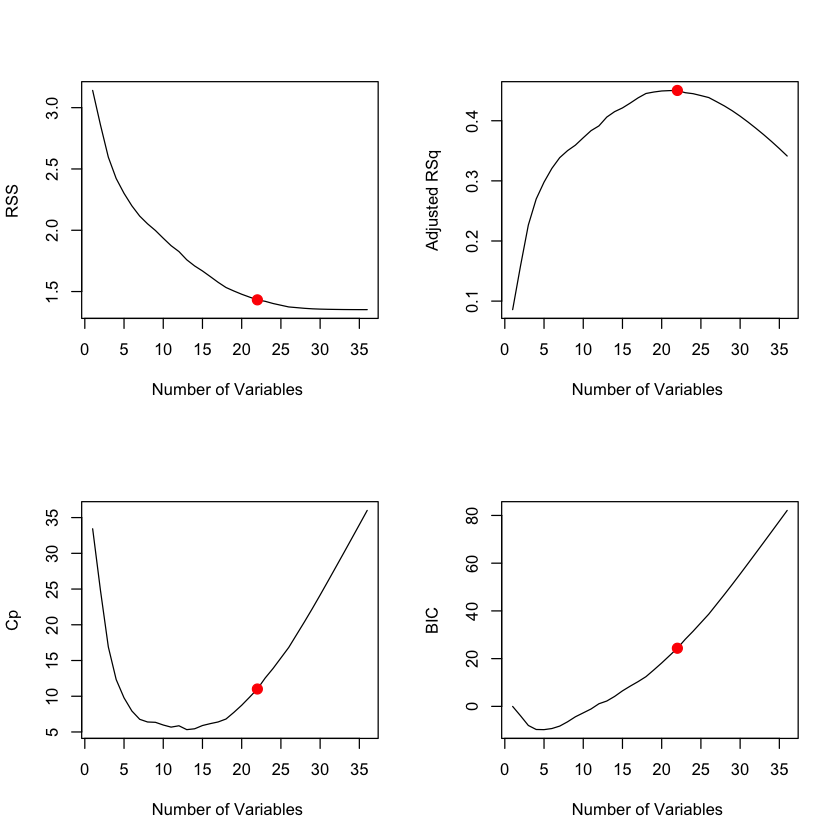

In [35]:
par(mfrow=c(2,2))

num_vars = which.max(reg.summary$adjr2)

plot(reg.summary$rss ,xlab="Number of Variables ",ylab="RSS", type="l")
points(num_vars,reg.summary$rss[num_vars], col="red",cex=2,pch=20)

plot(reg.summary$adjr2 ,xlab="Number of Variables ", ylab="Adjusted RSq",type="l")
points(num_vars, reg.summary$adjr2[num_vars], col='red', cex=2, pch=20)

plot(reg.summary$cp, xlab='Number of Variables ', ylab='Cp', type='l')
points(num_vars, reg.summary$cp[num_vars], col='red', cex=2, pch=20)

plot(reg.summary$bic, xlab='Number of Variables ', ylab='BIC', type='l')
points(num_vars, reg.summary$bic[num_vars], col='red', cex=2, pch=20)

In [36]:
best_features <- names(coef(regfit.full, num_vars))[-1]

best_features

[1] "TD_rush_off"      "`Yds/G_pass_off`" "Pct_off"          "TD_pass_off"     
 [5] "Rate_off"         "`Pts/G_off`"      "`Pen Yds_off`"    "TO"              
 [9] "`Yds/G_rush_def`" "TD_rush_def"      "Pct_def"          "`Pts/G_def`"     
[13] "`Pen Yds_def`"    "LB"               "WR"               "nDL"             
[17] "nLB"              "nOL"              "nQB"              "nRB"             
[21] "nS"               "nWR"

In [277]:
X_best <- X[colnames(X) %in% best_features]

,Pct_off,TD_pass_off,TO,TD_rush_def,LB,OL,QB,RB,TE,nOL,nQB,nRB,nS,nTE,nWR
1,-1.7489018828,-1.8444417,-0.1038322,-0.1129940,-0.862922406,-0.4739616,-1.0091106,-0.28572114,-0.63581405,-0.58345964,0.07075409,0.2262351,-0.06451954,0.8708234,-0.8389772
2,0.2865635184,-0.1286820,-0.1038322,-1.7149337,-0.378863073,-1.3291811,0.3456513,-1.07292391,-0.52356674,-1.22727718,0.07075409,1.0131399,-1.88624777,0.8708234,-0.8389772
3,-1.5140404904,-0.5246265,0.8306575,-0.7995395,-0.544243274,1.1398289,-0.2207425,-1.00792167,-0.38128596,0.06035789,0.07075409,0.2262351,-1.27900503,0.8708234,0.5238284
4,0.1821806773,1.3231147,0.9344897,-0.7995395,0.008327268,-0.4561077,1.0511744,-0.36021751,-0.16728096,0.70417543,0.07075409,0.2262351,1.14996594,0.8708234,-0.1575744
5,-0.7311691822,0.3992441,0.0000000,0.8024002,0.457232141,1.1121233,2.2239380,-0.93061631,-0.12982062,1.34799296,1.32860462,1.0131399,-0.06451954,0.8708234,-0.1575744
7,1.6957318732,0.9271702,1.3498184,0.8024002,-0.340813790,-0.8843311,-0.4901656,-0.09718665,0.15673301,1.34799296,-1.18709643,0.2262351,-0.67176228,0.8708234,-0.8389772
8,1.4086790602,0.1352811,-0.7268253,0.3447031,-0.248414540,0.6960661,0.7181827,0.20650183,-1.62123627,1.34799296,0.07075409,0.2262351,0.54272320,-2.1363366,-0.8389772
9,1.0433391163,0.3992441,0.5191609,1.9466428,-1.457001869,-1.1332334,0.9298560,-1.35433886,-1.10000941,-0.58345964,-1.18709643,-1.3475745,-0.67176228,0.8708234,-0.8389772
10,1.0172434061,-0.5246265,-0.7268253,1.7177943,-1.347911429,-0.1861220,1.6823444,-1.32835722,-0.29090151,-1.87109471,-1.18709643,-1.3475745,0.54272320,0.8708234,0.5238284
11,1.9566889759,1.7190593,1.1421540,0.5735516,-1.855555157,0.6070764,1.9260472,-0.11071990,-0.81918473,0.06035789,-1.18709643,-1.3475745,-0.67176228,-1.1339499,0.5238284


In [67]:
train_size <- floor(0.7 * nrow(X))

set.seed(42)

train_ind <- sample(seq_len(nrow(X)), size=train_size)

X_train <- X[train_ind, ]
y_train <- y[train_ind, ]
team_year_train <- team_year[train_ind, ]

X_test <- X[-train_ind, ]
y_test <- y[-train_ind, ]
team_year_test <- team_year[-train_ind, ]

In [68]:
# install.packages('leaps')
library(leaps)